In [50]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

## Подключение к БД

In [51]:

data = sqlite3.connect("../data/checking-logs.sqlite")

## Берем данные с таблиц

- `Checker`

In [52]:
sql_request = """
SELECT uid, timestamp FROM checker
WHERE uid LIKE 'user_%'
"""

dataframe_checker = pd.read_sql(sql_request, data, parse_dates="timestamp")

In [53]:
dataframe_checker

,uid,timestamp
0,user_4,2020-04-17 05:19:02.744528
1,user_4,2020-04-17 05:22:35.249331
2,user_4,2020-04-17 05:22:45.549397
3,user_4,2020-04-17 05:34:14.691200
4,user_4,2020-04-17 05:34:24.422370
...,...,...
3202,user_1,2020-05-21 20:19:06.872761
3203,user_1,2020-05-21 20:22:41.785725
3204,user_1,2020-05-21 20:22:41.877806
3205,user_1,2020-05-21 20:37:00.129678


## Нужно разделить даты

In [54]:
dataframe_checker["hour"] = dataframe_checker["timestamp"].dt.hour

dataframe_checker["day_number"] = dataframe_checker["timestamp"].dt.day

In [55]:
dataframe_checker["type"] = dataframe_checker["day_number"].apply(lambda x: "weekend" if x >= 5 else "working day")

In [56]:
dataframe_checker

,uid,timestamp,hour,day_number,type
0,user_4,2020-04-17 05:19:02.744528,5,17,weekend
1,user_4,2020-04-17 05:22:35.249331,5,17,weekend
2,user_4,2020-04-17 05:22:45.549397,5,17,weekend
3,user_4,2020-04-17 05:34:14.691200,5,17,weekend
4,user_4,2020-04-17 05:34:24.422370,5,17,weekend
...,...,...,...,...,...
3202,user_1,2020-05-21 20:19:06.872761,20,21,weekend
3203,user_1,2020-05-21 20:22:41.785725,20,21,weekend
3204,user_1,2020-05-21 20:22:41.877806,20,21,weekend
3205,user_1,2020-05-21 20:37:00.129678,20,21,weekend


In [57]:
weekend = dataframe_checker[dataframe_checker["type"] == "weekend"].reset_index()

In [58]:
weekend

,index,uid,timestamp,hour,day_number,type
0,0,user_4,2020-04-17 05:19:02.744528,5,17,weekend
1,1,user_4,2020-04-17 05:22:35.249331,5,17,weekend
2,2,user_4,2020-04-17 05:22:45.549397,5,17,weekend
3,3,user_4,2020-04-17 05:34:14.691200,5,17,weekend
4,4,user_4,2020-04-17 05:34:24.422370,5,17,weekend
...,...,...,...,...,...,...
2683,3202,user_1,2020-05-21 20:19:06.872761,20,21,weekend
2684,3203,user_1,2020-05-21 20:22:41.785725,20,21,weekend
2685,3204,user_1,2020-05-21 20:22:41.877806,20,21,weekend
2686,3205,user_1,2020-05-21 20:37:00.129678,20,21,weekend


In [59]:
work_day = dataframe_checker[dataframe_checker["type"] == "working day"].reset_index()

In [60]:
work_day

,index,uid,timestamp,hour,day_number,type
0,708,user_29,2020-05-01 06:55:02.780101,6,1,working day
1,709,user_26,2020-05-01 11:07:51.696506,11,1,working day
2,710,user_26,2020-05-01 11:07:51.872817,11,1,working day
3,711,user_3,2020-05-01 11:29:17.988118,11,1,working day
4,712,user_3,2020-05-01 11:34:49.856654,11,1,working day
...,...,...,...,...,...,...
514,1222,user_4,2020-05-04 14:57:12.725343,14,4,working day
515,1223,user_4,2020-05-04 14:58:31.215023,14,4,working day
516,1224,user_4,2020-05-04 14:58:38.346497,14,4,working day
517,1225,user_4,2020-05-04 15:16:21.586167,15,4,working day


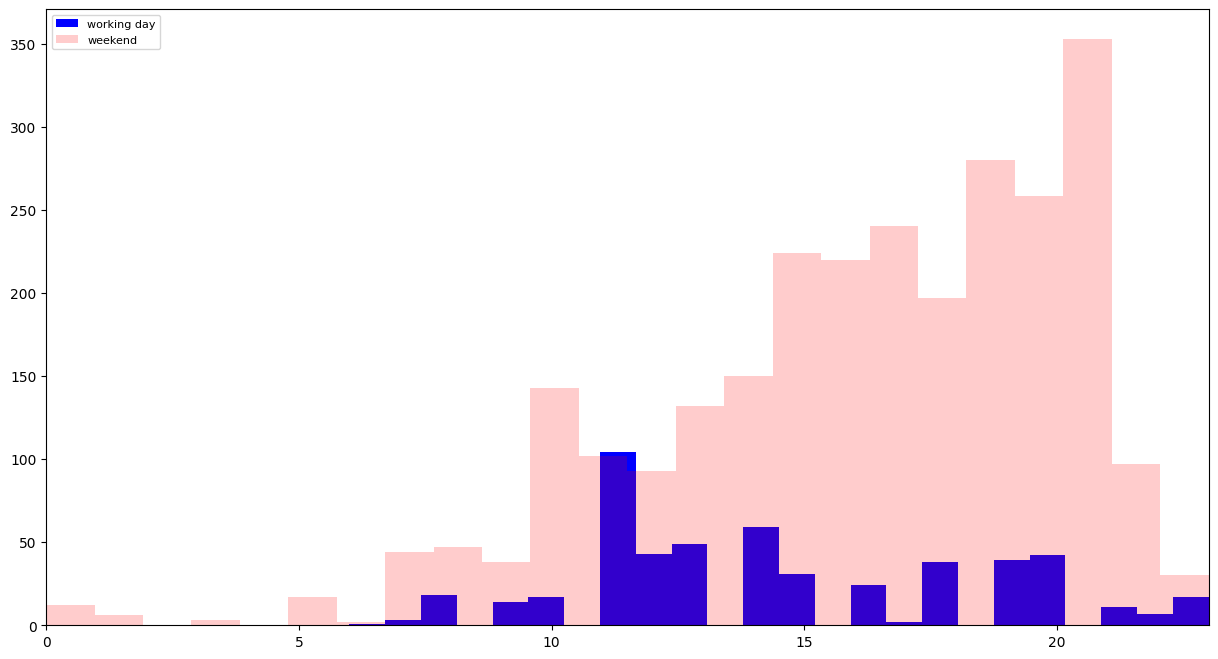

In [61]:
fig, ax = plt.subplots(figsize = (15, 8))

ax.hist(work_day["hour"], bins=24, color="blue", label="working day")

ax.hist(weekend["hour"], bins= 24, color="red",alpha = 0.2, label="weekend")

ax.set_xlim(0, 23)

ax.legend(loc="upper left", fontsize=8)

plt.show()

## Есть ли часы, когда общее количество коммитов было больше в выходные, чем в рабочие дни

In [62]:
we = weekend.groupby('hour').count().reset_index()
wo = work_day.groupby('hour').count().reset_index()

merged = pd.merge(we, wo, on='hour', how='outer', suffixes=('_weekend', '_workday')).fillna(0)

answer = merged[merged['uid_weekend'] > merged['uid_workday']]

answer = answer.rename(columns={'uid_weekend': 'count'})

result = answer[['hour', 'count']].sort_values('count', ascending=False).iloc[:4].set_index('hour')

In [64]:
result

,count
hour,
21,353
19,280
20,258
17,240


In [63]:
data.close()